In [1]:
import sys
sys.path.insert(0, '..')

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from diaphanous import (
    REPORTS_PER_PLATFORM,
    ingest_reports_per_platform,
    long_ncmec_reports,
    wide_ncmec_reports,
    compare_all_platform_reports,
    show,
)

In [2]:
PKGS = [
    "iccCounts", "dplyr", "ggplot2", "patchwork",
    "purrr", "scales", "svglite", "this.path", "tidyr"
]

path = Path("..") / "rlib"
path.mkdir(exist_ok=True)
RLIB = str(path)

%load_ext rpy2.ipython

import rpy2.robjects.packages as r_packages
from rpy2.robjects.vectors import StrVector

not_installed = [p for p in PKGS if not r_packages.isinstalled(p, lib_loc=RLIB)]
if not_installed:
    show(f"""
        <strong style='file-size: 1.2em'><em>
        Installing R package(s) {", ".join(not_installed)}. This may take a while...
        </em></strong>
    """)

    utils = r_packages.importr("utils")
    utils.chooseCRANmirror(ind=1)
    utils.install_packages(StrVector(not_installed), lib=RLIB)

In [3]:
show('<h1>CSAM Reports per Platform</h1>')
show('<h2>Ingesting Platform Disclosures</h2>')

def logger(format: str, *args, **kwargs) -> None:
    print(format.format(*args, **kwargs))

platform_data = ingest_reports_per_platform(REPORTS_PER_PLATFORM, logger=logger)

show('<h2>An Overview of Platform Disclosures</h2>')
show(platform_data.features, caption='Platforms and Their Disclosures')

Skipping metadata
➖ Alphabet (no CSAM data)
✅ Amazon
➖ Apple (no CSAM data)
➖ Automattic (no CSAM data)
➖ Aylo (no CSAM data)
✅ Discord
✅ Facebook
✅ GitHub
✅ Google
✅ Instagram
✅ LinkedIn
➖ Meta (no CSAM data)
✅ Microsoft
➖ Omegle (no CSAM data)
✅ Pinterest
✅ Pornhub
➖ Quora (no CSAM data)
✅ Reddit
✅ Snap
➖ Telegram (no transparency disclosures)
✅ TikTok
➖ Tumblr (no CSAM data)
✅ Twitch
✅ Twitter
➖ WhatsApp (no CSAM data)
➖ Wikimedia (no transparency disclosures)
➖ Wordpress (no CSAM data)
✅ X
✅ YouTube
✅ NCMEC


,data,history,terms,quantities,granularity,frequency,coverage,has_reports
platform,,,,,,,,
Alphabet,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Amazon,⋯,linked list of pages,CSAM,counts,Y,Y,2020,True
Apple,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Automattic,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Aylo,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Discord,csv,same page (dropdown),child safety; CSAM,counts,Q,Q,2020 H2,True
Facebook,csv,data,child nudity & sexual exploitation; child sexual exploitation,rounded,Q,Q,2018 Q3,False
GitHub,⋯,same page (dropdown),CSEAI,counts,Y,Y,2021,True
Google,⋯,same page (dropdown),CSAM,counts,H,H,2020 H1,True


In [4]:
show('<h2>Ranking Service Providers by CyberTipline Report Counts</h2>')

ncmec = long_ncmec_reports(platform_data)
totals = ncmec[ncmec['platform'] == 'Total']['reports']

year = ncmec.index.min()
stop = ncmec.index.max()

while year <= stop:
    yearly = (
        ncmec.loc[year]
        .sort_values('reports', ascending=False)
        .assign(reports_pct=lambda df: df['reports'] / totals[year] * 100)
    )

    yearly.loc[yearly['platform'].isin(['ESP Total', 'Total']), 'reports_pct'] = np.NaN
    yearly['cumpct'] = yearly['reports_pct'].cumsum()

    show(
        yearly,
        caption=f' Social Media by CSAM Reports Filed in {year}',
    )
    year += 1

,platform,reports,reports_pct,cumpct
period,,,,
2019,Total,"16,987,361",⋯,⋯
2019,ESP Total,"16,836,694",⋯,⋯
2019,Meta,"15,884,511",93.50782031,93.5
2019,Alphabet,"449,283",2.64480751,96.2
2019,Microsoft,"123,929",0.72953651,96.9
2019,Snap,"82,030",0.48288843,97.4
2019,X,"45,726",0.26917660,97.6
2019,Discord,"19,480",0.11467349,97.7
2019,Automattic,"10,443",0.06147512,97.8


,platform,reports,reports_pct,cumpct
period,,,,
2020,Total,"21,751,085",⋯,⋯
2020,ESP Total,"21,447,786",⋯,⋯
2020,Meta,"20,307,216",93.36185298,93.4
2020,Alphabet,"546,704",2.51345623,95.9
2020,Snap,"144,095",0.66247270,96.5
2020,Microsoft,"96,838",0.44520997,97.0
2020,X,"65,062",0.29912071,97.3
2020,TikTok,"22,692",0.10432583,97.4
2020,Omegle,"20,265",0.09316777,97.5


,platform,reports,reports_pct,cumpct
period,,,,
2021,Total,"29,397,681",⋯,⋯
2021,ESP Total,"29,157,083",⋯,⋯
2021,Meta,"26,885,302",91.4538191,91.5
2021,Alphabet,"875,783",2.9790887,94.4
2021,Snap,"512,522",1.7434096,96.2
2021,TikTok,"154,618",0.5259531,96.7
2021,X,"86,666",0.2948056,97.0
2021,Microsoft,"78,887",0.2683443,97.3
2021,Omegle,"46,924",0.1596180,97.4


,platform,reports,reports_pct,cumpct
period,,,,
2022,Total,"32,059,029",⋯,⋯
2022,ESP Total,"31,802,525",⋯,⋯
2022,Meta,"27,190,665",84.8143748,84.8
2022,Alphabet,"2,174,548",6.7829503,91.6
2022,Omegle,"608,601",1.8983763,93.5
2022,Snap,"551,086",1.7189728,95.2
2022,TikTok,"288,125",0.8987328,96.1
2022,Discord,"169,800",0.5296480,96.6
2022,Microsoft,"108,804",0.3393864,97.0


,platform,reports,reports_pct,cumpct
period,,,,
2023,Total,"36,210,368",⋯,⋯
2023,ESP Total,"35,944,826",⋯,⋯
2023,Meta,"30,658,047",84.6664883,84.7
2023,Alphabet,"1,470,958",4.0622564,88.7
2023,X,"870,503",2.4040159,91.1
2023,Snap,"713,055",1.9692012,93.1
2023,TikTok,"590,376",1.6304060,94.7
2023,Discord,"339,412",0.9373337,95.7
2023,Reddit,"290,141",0.8012650,96.5


In [5]:
show("<h3>Meta, Google, and the Rest</h3>")

data = (
    # Select rows with actual platform data
    ncmec[~ncmec['platform'].isin(['Total', 'ESP Total'])]
    # Compute yearly report percentage
    .assign(reports_pct=lambda df: df['reports'] / df.groupby(df.index)['reports'].sum() * 100)
    # Sort in descending order
    .sort_values('reports_pct', ascending=False)
    # Drop the reports column
    .drop(columns=['reports'])
    # Select rows with more than one percent
    .query("reports_pct > 2.5")
)

missing = (100 - data.groupby(data.index)['reports_pct'].sum()).to_frame()
missing['platform'] = 'Others'

data = pd.concat([data, missing]).pivot(columns='platform', values='reports_pct').fillna(0.0)
#data = data[['Meta', 'Alphabet', 'X', 'Snap', 'Omegle', 'TikTok', 'Others']]
data = data[['Meta', 'Alphabet', 'Others']]
data = data.rename(columns={'Alphabet': 'Google'})

show(data)

platform,Meta,Google,Others
period,,,
2019,95.5,2.70,1.77
2020,95.6,2.57,1.86
2021,93.6,3.05,3.37
2022,86.7,6.93,6.35
2023,86.7,4.16,9.18


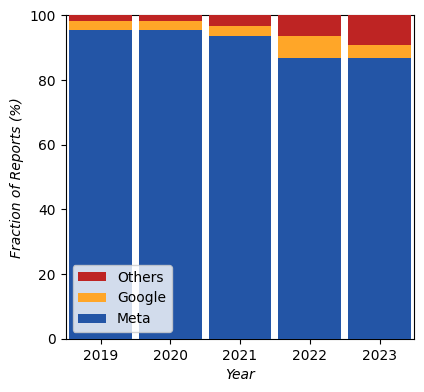

In [6]:
COLORS = ["#2355a6", "#ffa628", "#be2423", "#be2423"]

def plot(data, ax, colors):
    data.plot.bar(
        ax=ax,
        stacked=True,
        zorder=3,
        width=0.9,
        color = colors,
        figsize=[4.5, 4.2],
    )
    ax.set_xlim(-0.5, 4.5)
    ax.set_xlabel('Year', fontstyle='italic')
    ax.set_ylabel('Fraction of Reports (%)', fontstyle='italic')
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_ylim(top=100)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])

fig, ax = plt.subplots()
plot(data, ax, COLORS)

fig.savefig('../figure/platforms-share.svg')

In [7]:
show('<h2>Per Service Provider Disclosures: Provider vs NCMEC</h2>')

# No piece counts are available for the rest of Microsoft in 2019.
# So we drop LinkedIn's data, which is in the noise already.
linkedin = platform_data.disclosures["LinkedIn"]
linkedin.loc[linkedin.index.year == 2019, "pieces"] = np.NaN
reddit = platform_data.disclosures["Reddit"]
reddit.loc[pd.Period("2023-01", freq="6M"), "pieces"] = np.NaN
github = platform_data.disclosures["GitHub"]
github.loc[github.index.year == 2023, "reports"] = np.NaN

comparisons = compare_all_platform_reports(platform_data)

from diaphanous.platform.compare import compare_twitch
twitch = compare_twitch(platform_data)
comparisons['Twitch'] = twitch

comparisons['Google'] = comparisons['Alphabet']
del comparisons['Alphabet']

brand_holders = len(platform_data.brands)
brand_holder_brands = sum(len(brands) for brands in platform_data.brands.values())
# Account for '@' and 'NCMEC':
surveyed_brands = len(REPORTS_PER_PLATFORM) - 1 - 1 - brand_holders
surveyed_firms = surveyed_brands - brand_holder_brands + brand_holders
# Account for 'NCMEC':
brands_with_disclosures = len(
    set(platform_data.disclosures) - set(platform_data.brands)
) - 1

show(
    f"""
    Out of {surveyed_brands} surveyed social media platforms owned by
    {surveyed_firms} firms, {brands_with_disclosures} brands make transparency
    disclosures. Furthermore, only {len(comparisons)} platforms disclose usable
    piece or report counts.
    """
)

provider_names = sorted(comparisons)
for provider in provider_names:
    if provider == 'Twitch':
        caption = 'Twitch (Also Included with Amazon)'
    else:
        caption = provider
    show(comparisons[provider], caption=caption, min_precision=3)

,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,549,0.00326,"16,836,694",0.00323,"16,987,361",99.113
2020,⋯,⋯,"2,235",≡,"2,235",0.01042,"21,447,786",0.01028,"21,751,085",98.606
2021,"27,244",0.805,"33,848",-0.0443,"33,833",0.11604,"29,157,083",0.11509,"29,397,681",99.182
2022,"52,656",0.785,"67,073",4.4946,"70,157",0.22060,"31,802,525",0.21884,"32,059,029",99.200
2023,"24,756",0.791,"31,281",3.3878,"32,359",0.09002,"35,944,826",0.08936,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,205,0.001218,"16,836,694",0.001207,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,265,0.001236,"21,447,786",0.001218,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,160,0.000549,"29,157,083",0.000544,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,234,0.000736,"31,802,525",0.000730,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,267,0.000743,"35,944,826",0.000737,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"10,443",0.0620,"16,836,694",0.0615,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"9,130",0.0426,"21,447,786",0.0420,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"4,821",0.0165,"29,157,083",0.0164,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"5,035",0.0158,"31,802,525",0.0157,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"19,591",0.0545,"35,944,826",0.0541,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,⋯,⋯,"16,836,694",⋯,"16,987,361",99.113
2020,⋯,⋯,"4,171",104.115,"13,229",0.06168,"21,447,786",0.06082,"21,751,085",98.606
2021,"20,401",2.259,"9,029",0.816,"9,103",0.03122,"29,157,083",0.03097,"29,397,681",99.182
2022,"9,588",4.804,"1,996",4.840,"2,095",0.00659,"31,802,525",0.00653,"32,059,029",99.200
2023,"7,313",2.922,"2,503",3.648,"2,596",0.00722,"35,944,826",0.00717,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"19,480",0.1157,"16,836,694",0.1147,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"15,324",0.0714,"21,447,786",0.0705,"21,751,085",98.606
2021,⋯,⋯,"24,623",18.378,"29,606",0.1015,"29,157,083",0.1007,"29,397,681",99.182
2022,⋯,⋯,"58,179",97.922,"169,800",0.5339,"31,802,525",0.5296,"32,059,029",99.200
2023,⋯,⋯,"164,478",69.433,"339,412",0.9443,"35,944,826",0.9373,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"449,283",2.668,"16,836,694",2.645,"16,987,361",99.113
2020,"4,437,853",8.100,"547,875",-0.2140,"546,704",2.549,"21,447,786",2.513,"21,751,085",98.606
2021,"6,696,497",7.694,"870,319",0.6259,"875,783",3.004,"29,157,083",2.979,"29,397,681",99.182
2022,"13,402,885",6.164,"2,174,319",0.0105,"2,174,548",6.838,"31,802,525",6.783,"32,059,029",99.200
2023,"7,955,169",5.404,"1,472,221",-0.0858,"1,470,958",4.092,"35,944,826",4.062,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,"37,400,000",2.354,⋯,⋯,"15,884,511",94.345,"16,836,694",93.508,"16,987,361",99.113
2020,"38,890,800",1.915,⋯,⋯,"20,307,216",94.682,"21,447,786",93.362,"21,751,085",98.606
2021,"78,012,400",2.902,⋯,⋯,"26,885,302",92.208,"29,157,083",91.454,"29,397,681",99.182
2022,"105,800,000",3.891,⋯,⋯,"27,190,665",85.498,"31,802,525",84.814,"32,059,029",99.200
2023,"63,300,000",2.065,⋯,⋯,"30,658,047",85.292,"35,944,826",84.666,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"123,929",0.736,"16,836,694",0.730,"16,987,361",99.113
2020,"1,256,449.000",13.029,"96,435.000",0.4170,"96,838",0.452,"21,447,786",0.445,"21,751,085",98.606
2021,"564,157.000",7.148,"78,930.000",-0.0545,"78,887",0.271,"29,157,083",0.268,"29,397,681",99.182
2022,"450,447.000",4.186,"107,605.000",1.1081,"108,804",0.342,"31,802,525",0.339,"32,059,029",99.200
2023,"402,630.000",2.861,"140,720.000",0.3667,"141,237",0.393,"35,944,826",0.390,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"3,470",0.0206,"16,836,694",0.0204,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"20,265",0.0945,"21,447,786",0.0932,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"46,924",0.1609,"29,157,083",0.1596,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"608,601",1.9137,"31,802,525",1.8984,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"188,102",0.5233,"35,944,826",0.5195,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"7,360",0.04371,"16,836,694",0.04333,"16,987,361",99.113
2020,⋯,⋯,"3,432",≡,"3,432",0.01600,"21,447,786",0.01578,"21,751,085",98.606
2021,"1,608",0.599,"2,684",-16.147,"2,283",0.00783,"29,157,083",0.00777,"29,397,681",99.182
2022,"37,136",1.127,"32,964",4.002,"34,310",0.10788,"31,802,525",0.10702,"32,059,029",99.200
2023,"57,774",1.145,"50,437",3.734,"52,356",0.14566,"35,944,826",0.14459,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,1,0.00000594,"16,836,694",0.00000589,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,2,0.00000932,"21,447,786",0.00000919,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,25,0.00008574,"29,157,083",0.00008504,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"2,242",0.00704975,"31,802,525",0.00699335,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"6,135",0.01706783,"35,944,826",0.01694266,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,724,≡,724,0.00430,"16,836,694",0.00426,"16,987,361",99.113
2020,⋯,⋯,"2,233",≡,"2,233",0.01041,"21,447,786",0.01027,"21,751,085",98.606
2021,"9,258",0.920,"10,059",≡,"10,059",0.03450,"29,157,083",0.03422,"29,397,681",99.182
2022,"80,888",1.538,"52,592",≡,"52,592",0.16537,"31,802,525",0.16405,"32,059,029",99.200
2023,⋯,⋯,"290,121",0.00689,"290,141",0.80718,"35,944,826",0.80126,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"82,030",0.487,"16,836,694",0.483,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"144,095",0.672,"21,447,786",0.662,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"512,522",1.758,"29,157,083",1.743,"29,397,681",99.182
2022,"1,273,838",2.313,"550,755",0.0601,"551,086",1.733,"31,802,525",1.719,"32,059,029",99.200
2023,"1,594,805",2.307,"691,225",3.1091,"713,055",1.984,"35,944,826",1.969,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,596,0.00354,"16,836,694",0.00351,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"22,692",0.10580,"21,447,786",0.10433,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"154,618",0.53029,"29,157,083",0.52595,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"288,125",0.90598,"31,802,525",0.89873,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"590,376",1.64245,"35,944,826",1.63041,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
year,,,,,,,,,,
2020,⋯,⋯,"2,158",⋯,⋯,0.0101,"21,447,786",0.00992,"21,751,085",98.606
2021,⋯,⋯,"6,621",0.121,"6,629",0.0227,"29,157,083",0.02255,"29,397,681",99.182
2022,⋯,⋯,"14,296",1.472,"14,508",0.0456,"31,802,525",0.04525,"32,059,029",99.200
2023,⋯,⋯,"6,557",1.634,"6,665",0.0185,"35,944,826",0.01841,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,13,0.0000772,"16,836,694",0.0000765,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,11,0.0000513,"21,447,786",0.0000506,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,8,0.0000274,"29,157,083",0.0000272,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,29,0.0000912,"31,802,525",0.0000905,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,34,0.0000946,"35,944,826",0.0000939,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"45,726",0.272,"16,836,694",0.269,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"65,062",0.303,"21,447,786",0.299,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"86,666",0.297,"29,157,083",0.295,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"98,050",0.308,"31,802,525",0.306,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"870,503",2.422,"35,944,826",2.404,"36,210,368",99.267


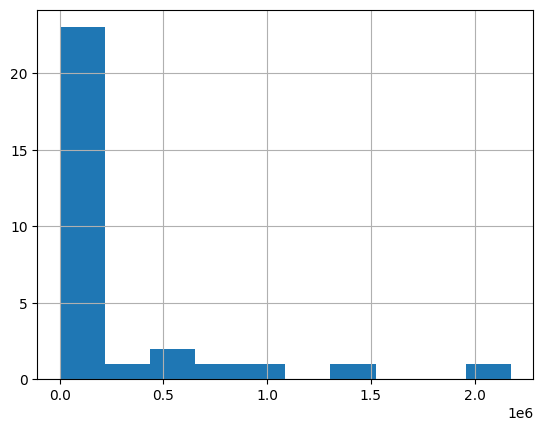

In [8]:
show("<h2>Comparable Report Counts</h2>")
show("<em style='font-size: 1.2em'>Building long data frame with comparable reports...</em>")

comparable_reports = None
for provider in provider_names:
    if provider == "Twitch":
        continue

    # We are only interested in years with report counts for platform and NCMEC
    data = comparisons[provider][["reports", "NCMEC"]]
    data = data[data["reports"].notna() & data["NCMEC"].notna()]
    if len(data) == 0:
        continue

    # Reshape as long frame with year, observer, count, and topic columns
    data = (data
        .assign(year=data.index.year)
        .reset_index(drop=True)
        .rename(columns={"reports": provider})
        .melt(id_vars="year", value_vars=["year", provider, "NCMEC"])
        .rename(columns={"variable": "observer", "value": "count"})
        .assign(topic=provider)
        .assign(count=lambda df: df["count"].astype("int64"))
    )

    if comparable_reports is None:
        comparable_reports = data
    else:
        comparable_reports = pd.concat([comparable_reports, data])

# The index repeats the same counts over and over again for each provider
comparable_reports = comparable_reports.reset_index(drop=True)
comparable_reports.to_csv("../data/comparable-reports-by-provider.csv", index=False)

show("<em style='font-size: 1.2em'>Erasing service provider identities from comparable reports...</em>")

cp = comparable_reports
cp.loc[cp["observer"] != "NCMEC", "observer"] = "ServiceProvider"
cp["id"] = cp["topic"].astype(str) + cp["year"].astype(str)
cp = cp[["id", "year", "observer", "count"]]
cp.to_csv("../data/comparable-reports.csv", index=False)

show("<h3>Distribution of Report Counts</h3>")
show("Possibly, not normal...")

counts1 = (
    cp[cp["observer"] == "ServiceProvider"]
    ["count"]
    .sort_values()
    .reset_index(drop=True)
    .hist()
)

In [9]:
%%R -i RLIB

.libPaths(RLIB)

library(dplyr)
library(ggplot2)
library(patchwork)
library(scales)
library(purrr)

data_path <- function(csv_name) {
  return(normalizePath(sprintf("../data/%s.csv", csv_name)))
}

format_mean_zero <- number_format()
format_mean_kilo <- number_format(scale=0.001, suffix="k")
format_mean_mega <- number_format(scale=0.000001, suffix="M")
format_mean <- function(x) {
  dplyr::case_when(
    is.na(x) ~ "",
    x == 0 ~ format_mean_zero(x),
    x < 1000000 ~ format_mean_kilo(x),
    TRUE ~ format_mean_mega(x)
  )
}

format_all_means <- function(xs) map(xs, format_mean)

plot_percent_diff_over_mean <- function(data, title) {
  data <- data |>
    group_by(id) |>
    summarize(
      Mean = mean(count),
      Diff = combn(count, diff, m=2),
      Year = factor(mean(year)) # mean() serves as identity function to quiet R warning
    ) |>
    mutate(PctDiff = Diff / Mean * 100)

  ymax <- max(abs(data$PctDiff))
  ymean <- mean(data$PctDiff)
  print(sprintf("The mean of the percentage differences is %.3f%%.", ymean))
  xmax <- max(data$Mean)
  xmin <- min(data$Mean)
  xrange <- xmax - xmin

  # A custom color palette derived from the Plasma scale:
  # > library(viridis)
  # > plasma(7)
  # Discard the first and last entries.
  color_selection <- c(
    "2019" = "#5D01A6",
    "2020" = "#9C179E",
    "2021" = "#CC4678",
    "2022" = "#ED7953",
    "2023" = "#FDB32F"
  )

  # Lines before points so that points are drawn above lines
  graph <- ggplot(data = data, aes(x = Mean, y = (PctDiff), color = Year)) +
    geom_hline(yintercept = 0) +
    geom_hline(yintercept = ymean, linetype = "dashed") +
    geom_point(size=2.5) +
    xlim(xmin - 0.05 * xrange, xmax + 0.05 * xrange) +
    ylim(ymax * (-1), ymax) +
    xlab(ifelse(title == "All Providers", "log(Mean)", "Mean")) +
    ylab("Δ% (Mean)") +
    labs(title = title)

  if (title == "Reddit") {
    # Reddit is the only provider with data for all five years.
    graph <- graph + scale_color_manual(values = color_selection)
  } else {
    graph <- graph + scale_color_manual(guide = "none", values = color_selection)
  }

  if (title == "All Providers") {
    graph <- graph + scale_x_continuous(labels = format_all_means, trans='log10')
  } else {
    graph <- graph + scale_x_continuous(labels = format_all_means)
  }

  graph <- graph + theme_light() #linedraw()
  return(graph)
}

per_provider_data <- read.csv(data_path("comparable-reports-by-provider"))
providers <- unique(per_provider_data$topic)
ba_plots <- vector("list", length(providers) + 1)

index <- 0
for (provider in providers) {
  index <- index + 1

  print("----------------------------------------------------------------------------")
  print(sprintf("Processing %s", provider))
  provider.data <- per_provider_data |> filter(topic == provider)
  provider.data$id <- provider.data$year
  ba_plots[[index]] <- plot_percent_diff_over_mean(provider.data, provider)
}

print("----------------------------------------------------------------------------")
all_data <- read.csv(data_path("comparable-reports"))
ba_plots[[length(providers) + 1]] <- plot_percent_diff_over_mean(
  all_data,
  "All Providers"
)

[1] "----------------------------------------------------------------------------"
[1] "Processing Amazon"
[1] "The mean of the percentage differences is 1.960%."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
[1] "----------------------------------------------------------------------------"
[1] "Processing Aylo"
[1] "The mean of the percentage differences is 28.355%."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
[1] "----------------------------------------------------------------------------"
[1] "Processing Discord"
[1] "The mean of the percentage differences is 61.911%."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
[1] "----------------------------------------------------------------------------"
[1] "Processing Google"
[1] "The mean of the percentage differences is 0.084%."
Scale for x is already present.
Adding another sca


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘purrr’

The following object is masked from ‘package:scales’:

    discard



In [10]:
show("<h3>Bland-Altman Plots: Percentage Difference vs Mean<h3>")

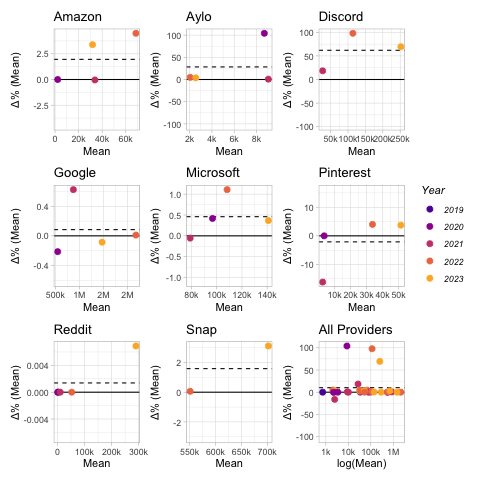

In [11]:
%%R
# Combine plots into 3x3 grid and display grid
grid <- wrap_plots(ba_plots, ncol=3, guides='collect') &
    theme(
        # legend.position = "bottom",
        legend.text = element_text(face = "italic"),
        legend.title = element_text(face = "italic")
    )
print(grid)
ggsave("../figure/comparable-reports.svg", grid, width=8, height=7)

In [12]:
show("<h3>Discord's Errors Are Discord's</h3>")

In [13]:
%%R

DiscordOutliers <- matrix(
    c(3, 2, 0, 25),
    nrow=2,
    dimnames=list(
        IsDiscord = c("Discord", "Other"),
        IsOutlier = c("Outlier", "Close")
    )
)

print(DiscordOutliers)

fisher.test(DiscordOutliers, alternative="greater")


         IsOutlier
IsDiscord Outlier Close
  Discord       3     0
  Other         2    25

	Fisher's Exact Test for Count Data

data:  DiscordOutliers
p-value = 0.002463
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 4.025159      Inf
sample estimates:
odds ratio 
       Inf 



In [14]:
show("<h3>Provider Bias for Undercounting</h3>")
show("""
    A positive percent difference means that the provider's count is smaller
    than NCMEC's, i.e., an undercount. The mean percentage difference for all
    providers but Pinterest is positive. Out of the underlying 30 pairs, 5 are
    negative, 6 are zero because of equal counts, and 19 are positive.

    The <a href="https://en.wikipedia.org/wiki/Sign_test">sign test</a> yields a
    p-value of 0.003305. We therefore reject the null hypothesis of no bias and
    accept the alternative hypothesis of bias.

    Technically, the bias could be providers favoring undercounts, NCMEC
    favoring overcounts, or both. At the same time, the incentive to underreport
    seems stronger for service providers. Discord's choice of reporting only
    some reports and Twitter disclosing only unique pieces seemingly reflect
    just that incentive.

    The reputational risk is real, see The Daily Beast's "Facebook Is a Hotbed
    of 'Child Sexual Abuse Material' with 20.3 Million Reports, Far More Than
    Pornhub."
""")

In [15]:
%%R

data <- read.csv("../data/comparable-reports-by-provider.csv") |>
  group_by(topic, year) |>
  summarize(the_mean = mean(count), the_difference = combn(count, diff, m=2)) |>
  mutate(pct_diff = the_difference / the_mean * 100) |>
  ungroup() |>
  select(topic, year, pct_diff) |>
  mutate(the_sign = sign(pct_diff)) |>
  group_by(the_sign) |>
  tally() |>
  print()

binom.test(x=19, n=24, p=0.5, alternative="greater", conf.level=0.95)

`summarise()` has grouped output by 'topic'. You can override using the
`.groups` argument.
# A tibble: 3 × 2
   the_sign     n
  <dbl[1d]> <int>
1        -1     5
2         0     6
3         1    19

	Exact binomial test

data:  19 and 24
number of successes = 19, number of trials = 24, p-value = 0.003305
alternative hypothesis: true probability of success is greater than 0.5
95 percent confidence interval:
 0.6108607 1.0000000
sample estimates:
probability of success 
             0.7916667 



In [16]:
# In descending order of report counts for 2023:
COLOR_BREWER = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
]

COLOR_GRIMM = [
    "#153dff",
    "#b32322",
    "#22a424",
    "#8727c0",
    "#824a01",
    "#0f6b94",
    "#a80590",
    "#69534f",
    "#545ba1",
    "#a04309",
    "#2d761d",
    "#0e70c7",
    "#b12145",
    "#6d48b6",
]

COLOR_OBSERVABLE = [
  "#4269d0", # blue
  "#efb118", # orange
  "#ff725c", # red
  "#6cc5b0", # cyan
  "#3ca951", # green
  "#ff8ab7", # pink
  "#a463f2", # purple
  "#97bbf5", # light blue
  "#9c6b4e", # brown
  "#9498a0", # gray
]

COLOR_GRIMM_OBSERVABLE = [
    # "#2b51c1", # blue
    # "#e18101", # orange
    # "#d6402c", # red
    # "#0aa78d", # cyan
    # "#e05f95", # pink
    # "#069335", # green
    # "#874bcb", # purple
    # "#5889d7", # light blue
    # "#8c5332", # brown
    # "#6c717d", # gray
    "#2b51c1", # blue
    "#e18101", # orange
    "#d6402c", # red
    "#0aa78d", # cyan
    "#874bcb", # purple
    "#069335", # green
    "#e05f95", # pink
    "#5889d7", # light blue
    "#8c5332", # brown
    "#6c717d", # gray
]

<Axes: xlabel='Year', ylabel='Reports'>

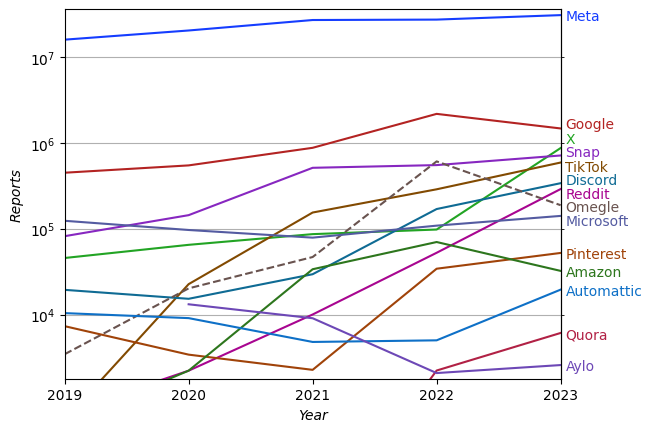

In [17]:
show("<h2>Report Counts Per Provider Per Year</h2>")

import matplotlib as mp
import matplotlib.pyplot as plt

# Currently unused:
def mega_tick(y: int | float, _pos: object) -> str:
    if y == 0:
        return "0"
    if y % 1_000_000 == 0:
        return format(int(y) // 1_000_000, ",") + "M"
    return format(int(y) / 1_000_000, ",") + "M"

ncmec = wide_ncmec_reports(platform_data).rename(columns={"Alphabet": "Google"})

OFFSETS = {
    "Meta": 0,
    "Google": 4,
    "X": 7.5,
    "Snap": 3.5,
    "TikTok": -2,
    "Discord": 3,
    "Reddit": -2.5,
    "Omegle": 0,
    "Microsoft": -2.5,
    "Pinterest": 0,
    "Amazon": 0,
    "Automattic": 0,
    "Quora": 0,
    "Aylo": 0,
}

ALL_PLATFORMS = list(OFFSETS.keys())

def plot(ax, platforms, colors, dash_omegle=False):
    settings = { p: (OFFSETS[p], c) for p, c in zip(platforms, colors)}

    ncmec[platforms].plot(ax=ax)

    ax.set_title(None)
    ax.legend().remove()
    ax.set_xlabel("Year", fontstyle="italic")
    # ax.get_yaxis().set_major_formatter(mp.ticker.FuncFormatter(mega_tick))
    ax.set_ylabel("Reports", fontstyle="italic")
    ax.grid(axis="y")
    ax.set_ylim(1800, 36_000_000)
    ax.set_yscale("symlog")

    positions = [ncmec.loc["2023", p] for p in platforms]
    alt = ax.secondary_yaxis(location="right")
    alt.set_ylim(1800, 36_000_000)
    alt.set_yscale("symlog")
    alt.set_yticks(positions, labels=platforms)
    alt.tick_params(axis="y", length=0)

    for platform, line, label in zip(platforms, ax.get_lines(), alt.get_yticklabels()):
        raw_offset, color = settings[platform]

        line.set_color(color)
        if platform == "Omegle" and dash_omegle:
            line.set_linestyle("dashed")
        label.set_color(color)

        if raw_offset != 0:
            offset = mp.transforms.ScaledTranslation(
                0, raw_offset/72, ax.figure.dpi_scale_trans
            )
            label.set_transform(label.get_transform() + offset)

    return ax

fig, ax = plt.subplots()
plot(ax, ALL_PLATFORMS, COLOR_GRIMM, dash_omegle=True)

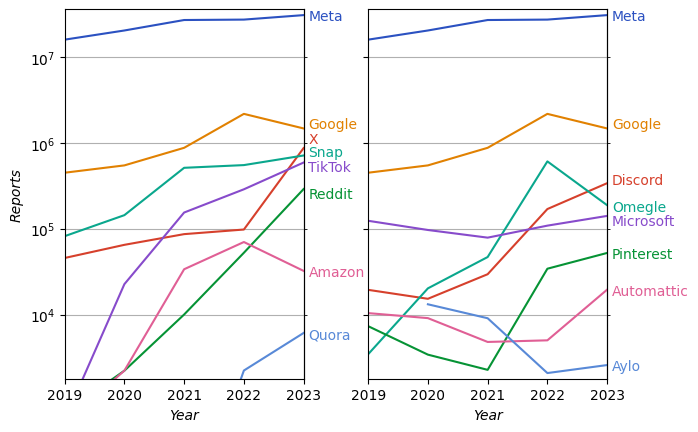

In [18]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=[7, 4.8],
    gridspec_kw=dict(wspace=0.27),
)

P1 = ['Meta', 'Google', 'X', 'Snap', 'TikTok', 'Reddit', 'Amazon', 'Quora']
P2 = ['Meta', 'Google', 'Discord', 'Omegle', 'Microsoft', 'Pinterest', 'Automattic', 'Aylo']

plot(ax1, P1, COLOR_GRIMM_OBSERVABLE)
plot(ax2, P2, COLOR_GRIMM_OBSERVABLE)
ax2.set_ylabel(None)
ax2.tick_params(labelleft=False)
fig.savefig("../figure/platforms.svg", bbox_inches='tight')